# 18장 전이 학습을 통해 딥러닝의 성능 극대화하기

## 1. 소규모 데이터셋으로 만드는 강력한 학습 모델

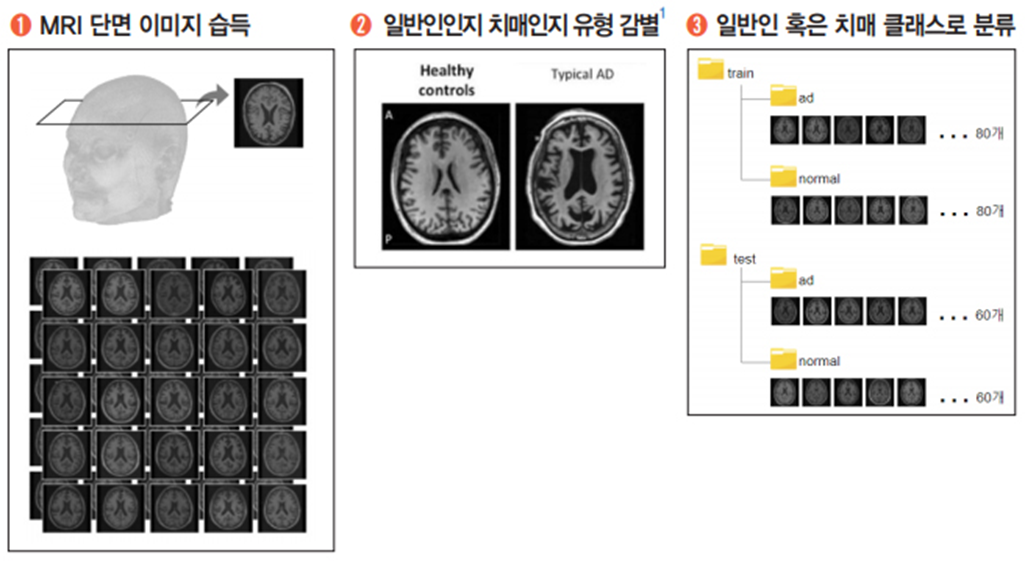<br />
test폴더에는 ad와 normal이라는 폴더가 있는데 뇌 사진에 대한 이미지 이다. <br />
알츠하이머인 사람의 뇌와 정상인의 사람의 뇌를 보면 서로 차이가 나는 것을 알 수 있다.<br />
실제 사진은 아니라 재 가공한 이미지를 모아놓은 것이다. 학습셋 정상인 사진과 알츠하이머 사진 가각 80개의 이미지가 있다. 테스트 셋도 각각 60개의 이미지가 있다.

ImageDataGenerator() 함수는 주어진 데이터를 이용해 변형된 이미지를 만들어 학습셋에 포함시키는 편리한 기능<br />
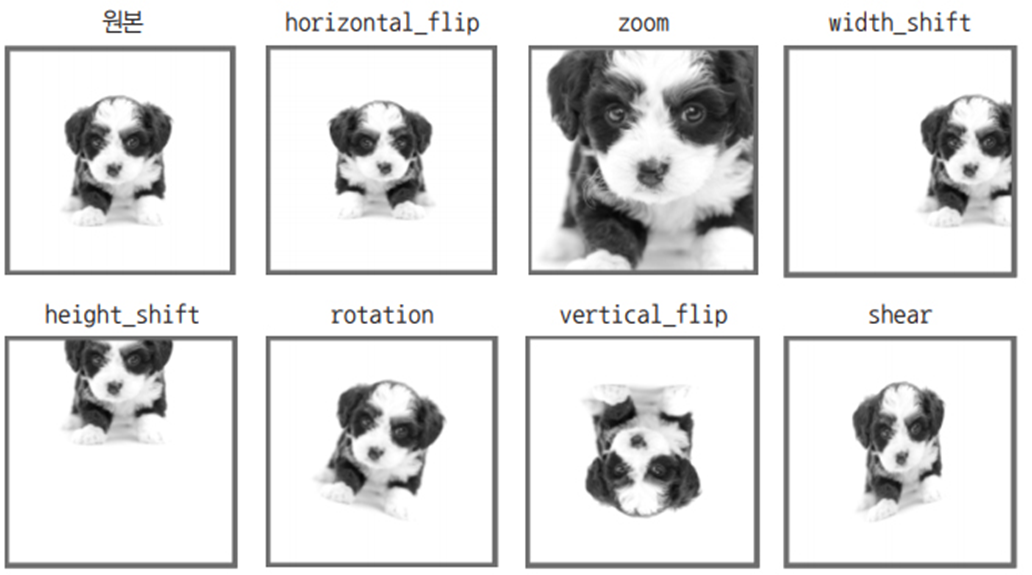 <br />
위 그림 처럼 원본 이미지를 조금씩 변형시키는 것이다.<br />
데이터가 적을 때 이렇게 하면 많은 데이터를 확보할 수 있다. 학습셋을 준비하는 과정중에 하나이다.<br />
학습셋은 많은 데이터가 필요하여 변형된 데이터를 많이 가지고 있는 것이 좋겠지만 테스트셋은 주어진 데이터로만 하는 것이 좋다.

### 실습: 치매 환자의 뇌인지 일반인의 뇌인지 예측하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

#학습셋의 변형을 설정하는 부분입니다. 
                                        # 1./255 : 0~1사이의 값을 가지도록 설정 
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )      

train_generator = train_datagen.flow_from_directory(
       './data/train',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150), # 이미지의 사이즈가 150*150이다.
       batch_size=5,
       class_mode='binary') # 치매인지 아닌지를 구분하기 위해서 binary로

# 테스트셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)  # 데스트셋은 ImageDataGenerator로 주어진 이미지의 크기를 설정을 하지만 나머지는 하지 않는다.

test_generator = test_datagen.flow_from_directory(
       './data/test',   # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary') 

# 앞서 배운 CNN 모델을 만들어 적용해 보겠습니다.
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
________________________________________

In [2]:
!pip install SciPy

In [3]:
#모델 실행의 옵션을 설정합니다. 
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5) # 검증셋

#모델을 실행합니다
history = model.fit(
       train_generator,
       epochs=100,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 3s 68ms/step - loss: 0.7053 - accuracy: 0.5063 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 2s 66ms/step - loss: 0.7028 - accuracy: 0.5125 - val_loss: 0.6904 - val_accuracy: 0.4800
Epoch 3/100
32/32 [==============================] - 2s 74ms/step - loss: 0.6913 - accuracy: 0.5188 - val_loss: 0.6883 - val_accuracy: 0.4800
Epoch 4/100
32/32 [==============================] - 2s 71ms/step - loss: 0.6854 - accuracy: 0.5375 - val_loss: 0.6786 - val_accuracy: 0.8200
Epoch 5/100
32/32 [==============================] - 2s 75ms/step - loss: 0.6756 - accuracy: 0.5750 - val_loss: 0.6573 - val_accuracy: 0.6400
Epoch 6/100
32/32 [==============================] - 2s 76ms/step - loss: 0.6825 - accuracy: 0.5813 - val_loss: 0.6378 - val_accuracy: 0.8400
Epoch 7/100
32/32 [==============================] - 2s 64ms/step - loss: 0.6558 - accuracy: 0.6313 - val_loss: 0.6667 - val_accuracy: 0.5000
Epoch 

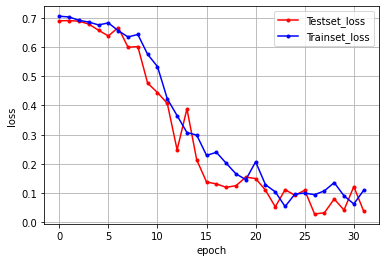

In [4]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. 전이 학습으로 모델 성능 극대화하기

In [ ]:
전이 학습이란 이미 학습된 모듈을 가져와서 학습을 시키는 것을 의미한다.

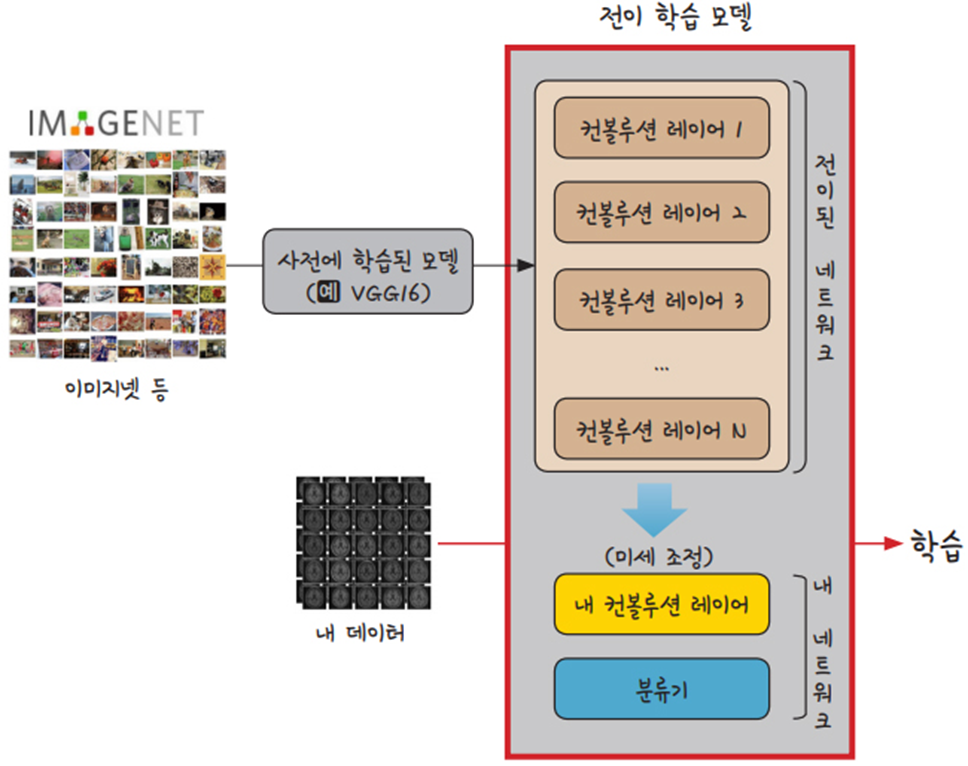<br />이미 이미지 학습된 모듈이 VGG16인 것이다.

### 실습: 전이 학습 실습하기

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# 학습셋의 변형을 설정하는 부분입니다. 
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )      


train_generator = train_datagen.flow_from_directory(
       './data/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋의 정규화를 설정합니다.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       './data/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# VGG16 모델을 불러옵니다.  추가 학습을 하기 위해 사전에 학습된 모델을 가지고 온다.
###                     # imagenet에 있는 이미지 가져 옴
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False # False : 학습을 하지 않는다.
transfer_model.summary()

# 우리의 모델을 설정합니다.
finetune_model = models.Sequential()
finetune_model.add(transfer_model)  # 사전에 학습된 데이터를 추가한다.
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
58900480/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 12

In [6]:
# 모델의 실행 옵션을 설정합니다. 
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = finetune_model.fit(
       train_generator,  
       epochs=20,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/20
32/32 [==============================] - 7s 217ms/step - loss: 0.7590 - accuracy: 0.5688 - val_loss: 0.5409 - val_accuracy: 0.7800
Epoch 2/20
32/32 [==============================] - 7s 224ms/step - loss: 0.5509 - accuracy: 0.7125 - val_loss: 0.5420 - val_accuracy: 0.7600
Epoch 3/20
32/32 [==============================] - 7s 208ms/step - loss: 0.4324 - accuracy: 0.8188 - val_loss: 0.4058 - val_accuracy: 0.8200
Epoch 4/20
32/32 [==============================] - 7s 217ms/step - loss: 0.4192 - accuracy: 0.8313 - val_loss: 0.3407 - val_accuracy: 0.9200
Epoch 5/20
32/32 [==============================] - 7s 208ms/step - loss: 0.3139 - accuracy: 0.8813 - val_loss: 0.2570 - val_accuracy: 0.9600
Epoch 6/20
32/32 [==============================] - 7s 220ms/step - loss: 0.2795 - accuracy: 0.9125 - val_loss: 0.2508 - val_accuracy: 0.9200
Epoch 7/20
32/32 [==============================] - 7s 228ms/step - loss: 0.2519 - accuracy: 0.9125 - val_loss: 0.3089 - val_accuracy: 0.8600
Epoch 

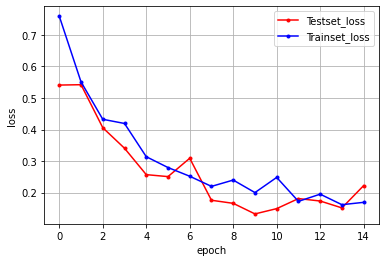

In [7]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model.save('dementia_cnn_model.h5')
print("모델이 저장되었습니다.")

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model('dementia_cnn_model.h5')
print("모델이 성공적으로 불러와졌습니다.")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import numpy as np

# -----------------------------
# 1. 모델 불러오기
# -----------------------------
model = load_model('dementia_cnn_model.h5')
print("모델이 성공적으로 불러와졌습니다.")

# -----------------------------
# 2. 데이터 제너레이터 (25% 검증 분리)
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # 데이터 증강
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25     # 학습 데이터 중 25%를 검증용으로 사용
)

# 학습용 데이터
train_generator = train_datagen.flow_from_directory(
    './data/train',           # 학습 데이터 디렉토리
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'         # 학습용 데이터
)

# 검증용 데이터
val_generator = train_datagen.flow_from_directory(
    './data/train',           # 같은 디렉토리에서 검증 데이터도 뽑음
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'       # 검증용 데이터
)
'''
validation_split=0.25
subset='training'
   전체 데이터 중 1 - validation_split (즉, 75%) 부분만 가져옴.
subset='validation' 
   전체 데이터 중 validation_split (즉, 25%) 부분만 가져옴.
'''

# -----------------------------
# 3. 콜백 설정 (EarlyStopping)
# -----------------------------
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,   # 3 epoch 동안 개선 없으면 중단
    restore_best_weights=True
)

# -----------------------------
# 4. 추가 학습 진행
# -----------------------------
history = model.fit(
    train_generator,
    epochs=10,                # 추가 학습할 epoch 수
    validation_data=val_generator,
    callbacks=[early_stopping_callback]
)
# 다시 저장
model.save('dementia_cnn_model.h5')

In [ ]:
#이미지 하나 예측
from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 불러오기 및 전처리
img_path = './data/predict/sample.jpg'  # 예측할 이미지 경로
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0  # 정규화
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

# 예측
prediction = model.predict(img_array)

# 결과 출력
if prediction[0][0] > 0.5:
    print(f"해당 이미지는 '치매 환자'로 예측됨. (확률: {prediction[0][0]:.2f})")
else:
    print(f"해당 이미지는 '정상'으로 예측됨. (확률: {1 - prediction[0][0]:.2f})")